<a href="https://colab.research.google.com/github/UkeshThapa/Snowmelt-Driven-Streamflow-Prediction/blob/main/snow_melting_research_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Snow Melting Prediction With LSTM, TCN and Transformer**

## install required library

In [119]:
# !pip install -U keras-tuner
# !pip install keras==2.12.0
# !pip install keras-tcn

## import Library

In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# normalize the data
from sklearn.preprocessing import StandardScaler,MinMaxScaler

# model library
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import SGD,RMSprop,Adam,Adadelta,Adagrad,Adamax,Nadam

# hyperparameter tuner
import keras_tuner as kt

# model checkpoint
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError,MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError


# loss


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


## Load Dataset

In [134]:

# Load your dataset

def load_dataset(path):
    return pd.read_csv(path)


file_path = "/content/drive/MyDrive/Colab Notebooks/dataset/bigdata.csv"
df_snow_melting = load_dataset(file_path)

df_snow_melting


,Date,Q,SCA,T,P,Day,Relative Humidity,Wind speed,Wind direction,Snow depth
0,1/1/2001,2.69,345.815123,-4.169740,0.000000,1,60.49,3.18,220.08,0.000170
1,1/2/2001,2.53,343.608727,-4.142604,0.000000,2,53.93,1.86,210.97,0.000133
2,1/3/2001,2.53,341.437417,-5.148725,0.000000,3,42.20,1.49,239.45,0.000128
3,1/4/2001,2.43,339.336277,-6.523695,0.031144,4,40.48,1.91,249.20,0.000122
4,1/5/2001,2.53,337.340394,-6.860106,0.000000,5,27.34,2.14,334.61,0.000116
...,...,...,...,...,...,...,...,...,...,...
4012,12/26/2012,2.91,228.615063,-5.651230,0.000000,361,46.49,1.43,257.42,0.000466
4013,12/27/2012,2.91,219.264614,-5.501225,0.000000,362,43.99,2.98,246.87,0.000437
4014,12/28/2012,3.03,210.043412,-5.526874,0.000000,363,27.19,2.54,263.59,0.000410
4015,12/29/2012,2.97,201.080703,-5.107484,0.000000,364,33.50,3.10,256.97,0.000379


## Dataset Pre-processing

In [135]:
features = ['Date',"Q","SCA","T"]
# features = ["Q"]
df_snow_melting = df_snow_melting[features]

In [137]:
import datetime

def str_to_datetime(s):
    split = s.split('/')
    month,day,year = int(split[0]),int(split[1]),int(split[2])

    return datetime.datetime(year=year,month=month,day=day)


In [138]:
df_snow_melting['Date'] = df_snow_melting['Date'].apply(str_to_datetime)

df_snow_melting

<ipython-input-138-164b30e8e586>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_snow_melting['Date'] = df_snow_melting['Date'].apply(str_to_datetime)


,Date,Q,SCA,T
0,2001-01-01,2.69,345.815123,-4.169740
1,2001-01-02,2.53,343.608727,-4.142604
2,2001-01-03,2.53,341.437417,-5.148725
3,2001-01-04,2.43,339.336277,-6.523695
4,2001-01-05,2.53,337.340394,-6.860106
...,...,...,...,...
4012,2012-12-26,2.91,228.615063,-5.651230
4013,2012-12-27,2.91,219.264614,-5.501225
4014,2012-12-28,3.03,210.043412,-5.526874
4015,2012-12-29,2.97,201.080703,-5.107484


## Data visualization in time series

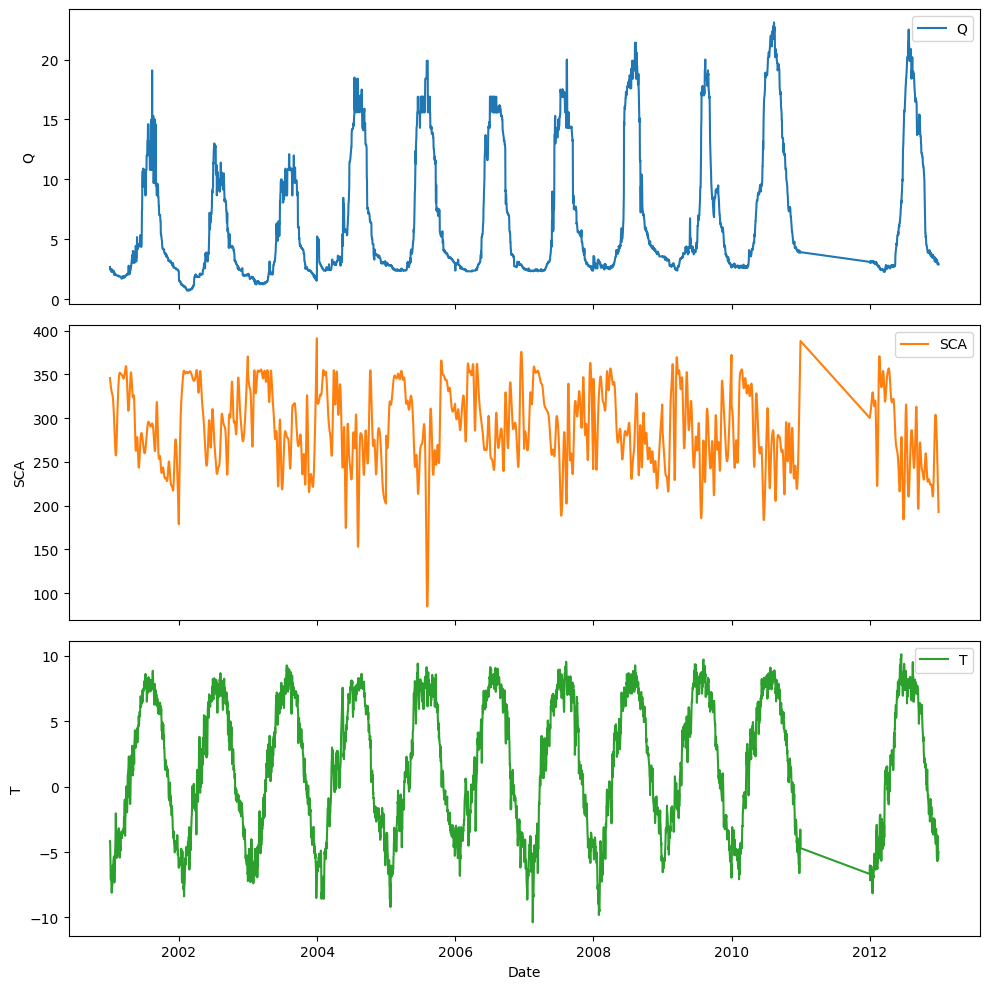

In [139]:
columns_to_plot = ['Q', 'SCA', 'T']

# Create subplots for each column
fig, axes = plt.subplots(len(columns_to_plot), 1, figsize=(10, 10), sharex=True)

for i, column in enumerate(columns_to_plot):
    axes[i].plot(df_snow_melting['Date'], df_snow_melting[column], label=column, color='C'+str(i))
    axes[i].set_ylabel(column)
    axes[i].legend()

# Set common x-label
axes[-1].set_xlabel('Date')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


In [140]:
df_input = df_snow_melting[['Q','SCA', 'T']]
df_input

,Q,SCA,T
0,2.69,345.815123,-4.169740
1,2.53,343.608727,-4.142604
2,2.53,341.437417,-5.148725
3,2.43,339.336277,-6.523695
4,2.53,337.340394,-6.860106
...,...,...,...
4012,2.91,228.615063,-5.651230
4013,2.91,219.264614,-5.501225
4014,3.03,210.043412,-5.526874
4015,2.97,201.080703,-5.107484


In [160]:
#[[[1],[2],[3],[4],[5]]][6]
#[[[2],[3],[4],[5],[6]]][7]
#[[[3],[4],[5],[6],[7]]][8]

def df_to_X_y(df, window_size = 5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

WINDOW_SIZE = 2

X, y = df_to_X_y(df_input,WINDOW_SIZE)

X.shape, y.shape

((4015, 2, 3), (4015,))

In [161]:
X_train, y_train = X[:3285],y[:3285] # 9 year 80%
X_val, y_val = X[3285:3648],y[3285:3648] # 363 days 10%
X_test, y_test = X[3648:],y[3648:]  # 364 day 10%


In [162]:
X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape

((3285, 2, 3), (3285,), (363, 2, 3), (363,), (367, 2, 3), (367,))

In [173]:
num_features =  X_train.shape[2]


In [174]:
# preprocess(X_train)
# preprocess(X_val)
# preprocess(X_test)

In [175]:
model = Sequential()
model.add(LSTM(20, activation='relu', return_sequences=False, input_shape=(WINDOW_SIZE, num_features)))
# model.add(LSTM(64, activation='relu', return_sequences=True))
# model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))
optimizer = Adamax(learning_rate=0.002,beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss=MeanSquaredError(), metrics=['mae',RootMeanSquaredError()])


In [181]:
cp = ModelCheckpoint('model1/',save_best_only=True)
early_stopping = EarlyStopping(monitor="val_loss",
                               patience = 10,
                               mode = 'min')

model.fit(X_train,y_train,batch_size=32,validation_data=(X_val,y_val),epochs=50,callbacks=[cp])


Epoch 1/50
103/103 [==============================] - 8s 48ms/step - loss: 4.8740 - mae: 1.3474 - root_mean_squared_error: 2.2077 - val_loss: 2.4549 - val_mae: 1.3226 - val_root_mean_squared_error: 1.5668
Epoch 2/50
103/103 [==============================] - 0s 4ms/step - loss: 4.5268 - mae: 1.2492 - root_mean_squared_error: 2.1276 - val_loss: 3.5590 - val_mae: 1.5885 - val_root_mean_squared_error: 1.8865
Epoch 3/50
103/103 [==============================] - 0s 4ms/step - loss: 3.9025 - mae: 1.1627 - root_mean_squared_error: 1.9755 - val_loss: 2.6507 - val_mae: 1.3380 - val_root_mean_squared_error: 1.6281
Epoch 4/50
103/103 [==============================] - 2s 23ms/step - loss: 4.3044 - mae: 1.1524 - root_mean_squared_error: 2.0747 - val_loss: 2.2813 - val_mae: 1.2488 - val_root_mean_squared_error: 1.5104
Epoch 5/50
103/103 [==============================] - 1s 5ms/step - loss: 3.5908 - mae: 1.0979 - root_mean_squared_error: 1.8949 - val_loss: 2.8915 - val_mae: 1.3387 - val_root_mean_

In [182]:
from tensorflow.keras.models import load_model

model = load_model('model1/')

103/103 [==============================] - 0s 2ms/step


MAE: 0.44844683943186725
RMSE: 0.6923790044938309
R-squared (R2): 0.9809608498942952


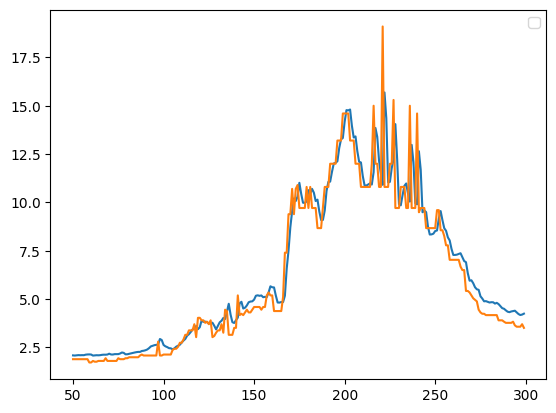

In [183]:

train_predictions = model.predict(X_train).flatten()
# train_predictions
train_result = pd.DataFrame(data={"Train Predictions":train_predictions,"Actuals":y_train})
# Calculate MAE
mae = mean_absolute_error(y_train, train_predictions)


# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_train, train_predictions))

# Calculate R2
r2 = r2_score(y_train, train_predictions)

print("MAE:", mae)
print("RMSE:", rmse)
print("R-squared (R2):", r2)

plt.plot(train_result['Train Predictions'][50:300])
plt.plot(train_result['Actuals'][50:300])
plt.legend()
plt.show()

12/12 [==============================] - 0s 5ms/step


MAE: 0.5048693039266202
RMSE: 0.7881542784085828
R-squared (R2): 0.98686260857002


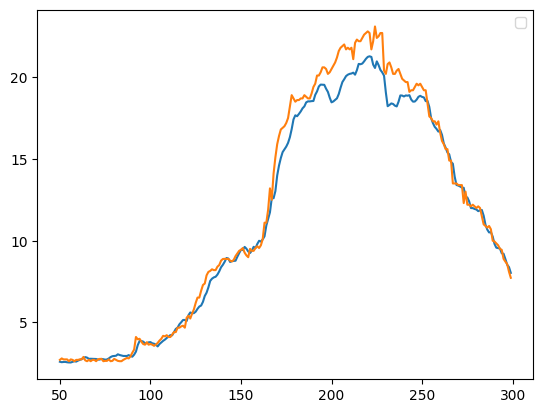

In [184]:
val_predictions = model.predict(X_val).flatten()


# Calculate MAE
mae = mean_absolute_error(y_val, val_predictions)


# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val, val_predictions))

# Calculate R2
r2 = r2_score(y_val, val_predictions)

print("MAE:", mae)
print("RMSE:", rmse)
print("R-squared (R2):", r2)


val_result = pd.DataFrame(data={"val Predictions":val_predictions,"Actuals":y_val})
plt.plot(val_result['val Predictions'][50:300])
plt.plot(val_result['Actuals'][50:300])
plt.legend()
plt.show()

12/12 [==============================] - 0s 2ms/step


MAE: 0.42655974861061857
RMSE: 0.6445506171248607
R-squared (R2): 0.9894951502545417


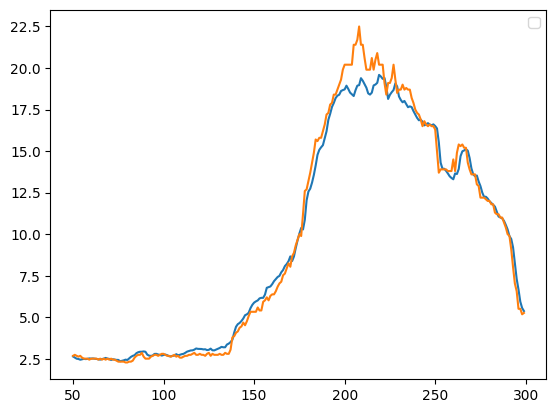

In [185]:
test_predictions = model.predict(X_test).flatten()

# Calculate MAE
mae = mean_absolute_error(y_test, test_predictions)


# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

# Calculate R2
r2 = r2_score(y_test, test_predictions)

print("MAE:", mae)
print("RMSE:", rmse)
print("R-squared (R2):", r2)


test_result = pd.DataFrame(data={"test Predictions":test_predictions,"Actuals":y_test})
plt.plot(test_result['test Predictions'][50:300])
plt.plot(test_result['Actuals'][50:300])
plt.legend()
plt.show()

## Data Normalization

In [184]:

# Initialize the MinMaxScaler
scaler = MinMaxScaler()


# df_snow_melting[columns_to_scale] = scaler.fit_transform(df_snow_melting[columns_to_scale])
df_scaled = scaler.fit_transform(df_snow_melting[['Q','SCA', 'T','P']])
df_scaled


array([[0.08757656, 0.85179121, 0.3027373 , 0.        ],
       [0.0804238 , 0.84459246, 0.3040619 , 0.        ],
       [0.0804238 , 0.83750818, 0.25494888, 0.        ],
       ...,
       [0.10277616, 0.40881226, 0.23648982, 0.        ],
       [0.10009388, 0.37956986, 0.25696202, 0.        ],
       [0.0974116 , 0.35159252, 0.26158629, 0.        ]])

In [101]:
# Define the feature columns (X) and target column (y)
# feature_columns = ['SCA', 'T']
# target_column = 'Q'

# X, y = df_snow_melting[feature_columns], df_snow_melting[target_column]

# X,y = X.values,y.values


features = df_scaled
target = df_scaled[:,0]
target

array([0.08757656, 0.0804238 , 0.0804238 , ..., 0.10277616, 0.10009388,
       0.0974116 ])

# Split dataset as train test and val


In [102]:

# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)  # 80% training and 20% test

# Further split the remaining data into validation and test sets
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 10% validation, 10% testing


In [103]:
print("Train shape",X_train.shape)
# print("val shape",X_val.shape)
print("Test shape",X_test.shape)

Train shape (3213, 4)
Test shape (804, 4)


In [160]:
win_length = 2
batch_size = 32
num_features = 4

train_generator = TimeseriesGenerator(X_train,y_train,length = win_length,sampling_rate = 1,batch_size=batch_size)
test_generator = TimeseriesGenerator(X_test,y_test,length = win_length,sampling_rate = 1,batch_size=batch_size)

In [161]:
train_generator[0]

(array([[[1.78327149e-01, 5.62164100e-01, 4.45800175e-01, 1.46654875e-02],
         [8.98117931e-02, 8.28109987e-01, 6.07312251e-01, 8.95422871e-03]],
 
        [[8.98117931e-02, 8.28109987e-01, 6.07312251e-01, 8.95422871e-03],
         [6.91537396e-01, 5.32304784e-01, 8.87182172e-01, 2.76773245e-01]],
 
        [[6.91537396e-01, 5.32304784e-01, 8.87182172e-01, 2.76773245e-01],
         [6.25419107e-02, 4.57033891e-01, 3.52811046e-01, 0.00000000e+00]],
 
        [[6.25419107e-02, 4.57033891e-01, 3.52811046e-01, 0.00000000e+00],
         [1.64468684e-01, 7.06111197e-01, 3.81835775e-01, 5.44615022e-03]],
 
        [[1.64468684e-01, 7.06111197e-01, 3.81835775e-01, 5.44615022e-03],
         [1.53739550e-01, 5.09121351e-01, 7.30085944e-01, 1.85319639e-03]],
 
        [[1.53739550e-01, 5.09121351e-01, 7.30085944e-01, 1.85319639e-03],
         [5.40480129e-02, 6.70111847e-01, 3.48592002e-01, 0.00000000e+00]],
 
        [[5.40480129e-02, 6.70111847e-01, 3.48592002e-01, 0.00000000e+00],
       

In [162]:
# #  reshape the data to fit in model for Lstm (3D array)
# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


# LSTM (Long Short Term Memory)

## Create model

In [164]:

model = Sequential()
model.add(LSTM(20, activation='relu', return_sequences=False, input_shape=(win_length, num_features)))
# model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))

optimizer = Adamax(learning_rate=0.01,beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 20)                2000      
                                                                 
 dropout_6 (Dropout)         (None, 20)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2021 (7.89 KB)
Trainable params: 2021 (7.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [165]:
early_stopping = EarlyStopping(monitor="val_loss",
                               patience = 10,
                               mode = 'min')


model.fit_generator(train_generator,
          validation_data=test_generator,
          epochs=100,
          callbacks=[early_stopping])


Epoch 1/100


<ipython-input-165-069724725692>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator,


101/101 [==============================] - 3s 8ms/step - loss: 0.0630 - mae: 0.2033 - mse: 0.0630 - val_loss: 0.0590 - val_mae: 0.1979 - val_mse: 0.0590
Epoch 2/100
101/101 [==============================] - 1s 6ms/step - loss: 0.0605 - mae: 0.2015 - mse: 0.0605 - val_loss: 0.0589 - val_mae: 0.2007 - val_mse: 0.0589
Epoch 3/100
101/101 [==============================] - 1s 8ms/step - loss: 0.0604 - mae: 0.2007 - mse: 0.0604 - val_loss: 0.0589 - val_mae: 0.2034 - val_mse: 0.0589
Epoch 4/100
101/101 [==============================] - 1s 8ms/step - loss: 0.0600 - mae: 0.2013 - mse: 0.0600 - val_loss: 0.0588 - val_mae: 0.2014 - val_mse: 0.0588
Epoch 5/100
101/101 [==============================] - 1s 6ms/step - loss: 0.0596 - mae: 0.2007 - mse: 0.0596 - val_loss: 0.0587 - val_mae: 0.1975 - val_mse: 0.0587
Epoch 6/100
101/101 [==============================] - 0s 4ms/step - loss: 0.0597 - mae: 0.2011 - mse: 0.0597 - val_loss: 0.0588 - val_mae: 0.2015 - val_mse: 0.0588
Epoch 7/100
101/101 [=

In [166]:
predictions = model.predict_generator(test_generator)

<ipython-input-166-9068eb02ed61>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator)


In [167]:
predictions.shape[0]*-1

-802

In [168]:
X_test[:,1:][win_length:]

array([[6.26105335e-01, 8.57303918e-01, 2.98103154e-01],
       [6.41198856e-01, 8.05115835e-01, 2.59600742e-02],
       [5.91363171e-01, 3.42179710e-01, 1.16957347e-04],
       ...,
       [5.94117327e-01, 8.19842554e-01, 9.80727947e-03],
       [3.24529472e-01, 9.06500070e-01, 1.09163677e-01],
       [6.57388214e-01, 3.57716487e-01, 3.11051774e-03]])

In [169]:
df_pred = pd.concat([pd.DataFrame(predictions),pd.DataFrame(X_test[:,1:][win_length:])],axis=1)

In [170]:
df_pred

,0,0,1,2
0,0.265609,0.626105,0.857304,0.298103
1,0.256234,0.641199,0.805116,0.025960
2,0.263268,0.591363,0.342180,0.000117
3,0.271620,0.825444,0.449301,0.001011
4,0.268955,0.856532,0.312288,0.000097
...,...,...,...,...
797,0.259459,0.845668,0.459308,0.000117
798,0.274009,0.753863,0.654477,0.050473
799,0.256637,0.594117,0.819843,0.009807
800,0.258301,0.324529,0.906500,0.109164


In [171]:
predictions.shape[0]

802

In [172]:
rev_trans = scaler.inverse_transform(df_pred)

In [173]:
rev_trans

array([[ 6.67240830e+00,  2.76643083e+02,  7.19101580e+00,
         4.31269875e+01],
       [ 6.46269546e+00,  2.81269201e+02,  6.12189980e+00,
         3.75567913e+00],
       [ 6.62004509e+00,  2.65994714e+02, -3.36172910e+00,
         1.69203780e-02],
       ...,
       [ 6.47172321e+00,  2.66838855e+02,  6.42358880e+00,
         1.41883242e+00],
       [ 6.50892484e+00,  1.84210992e+02,  8.19883960e+00,
         1.57928572e+01],
       [ 6.63653463e+00,  2.86231191e+02, -3.04344540e+00,
         4.50002819e-01]])

In [174]:
df_final = df_snow_melting[predictions.shape[0]*-1:]

In [175]:
df_final.count()

Date    802
Q       802
SCA     802
T       802
P       802
dtype: int64

In [176]:
df_final["Q_pred"] =  rev_trans[:,0]

<ipython-input-176-f9321c1a2bf8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["Q_pred"] =  rev_trans[:,0]


In [177]:
df_final

,Date,Q,SCA,T,P,Q_pred
3215,2009-10-21,9.44,270.276783,1.765881,0.984761,6.672408
3216,2009-10-22,9.50,272.191519,1.178754,0.000000,6.462695
3217,2009-10-23,8.72,272.851850,0.732791,0.223343,6.620045
3218,2009-10-24,8.62,271.572522,0.850095,0.000000,6.806859
3219,2009-10-25,8.41,267.928058,0.525221,0.000000,6.747253
...,...,...,...,...,...,...
4012,2012-12-26,2.91,228.615063,-5.651230,0.000000,6.534827
4013,2012-12-27,2.91,219.264614,-5.501225,0.000000,6.860311
4014,2012-12-28,3.03,210.043412,-5.526874,0.000000,6.471723
4015,2012-12-29,2.97,201.080703,-5.107484,0.000000,6.508925


<Axes: >

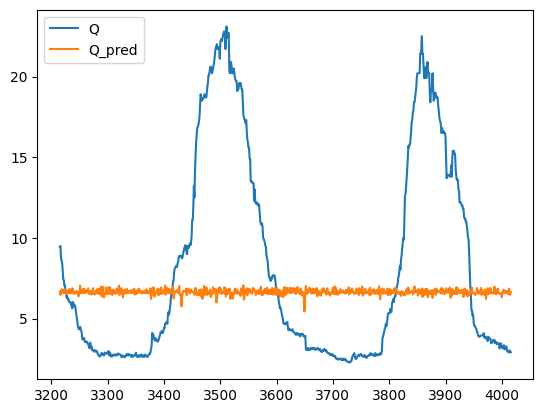

In [178]:
df_final[['Q',"Q_pred"]].plot()

# Hyperparameter Tuning

# find optimizers

In [158]:
def build_model(hp):
    model = Sequential()
    model.add(LSTM(32, activation='relu', return_sequences=False, input_shape=(6,3)))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='linear'))

    optimizer = hp.Choice('optimizer', values = ["sgd","rmsprop","adam","adadelta","adagrad","adamax","adam"])
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse',])

    return model


In [159]:
from sklearn.utils import validation
tuner  = kt.RandomSearch(build_model,
                         objective='val_loss',
                         max_trials=10)

tuner.search(X_train,y_train,epochs=5,validation_data=(X_val,y_val))

Trial 6 Complete [00h 00m 08s]
val_loss: 1.6287680864334106

Best val_loss So Far: 1.3862440586090088
Total elapsed time: 00h 01m 02s


In [ ]:
tuner.get_best_hyperparameters()[0].values


{'optimizer': 'sgd'}

In [ ]:
!rm -r /content/untitled_project

## Number of hidden units

In [ ]:
def build_model(hp):
    model = Sequential()

    units = hp.Int('units',min_value = 1,max_value = 128,step=5)

    model.add(LSTM(units=units, activation='relu', return_sequences=False, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='linear'))
    optimizer = hp.Choice('optimizer', values = ["sgd","rmsprop","adam","adadelta","adagrad","adamax","adam"])
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse',])

    return model



In [ ]:
from sklearn.utils import validation
tuner  = kt.RandomSearch(build_model,
                         objective='val_mae',
                         max_trials=100)

tuner.search(X_train,y_train,epochs=5,validation_data=(X_val,y_val))

Trial 100 Complete [00h 00m 05s]
val_mae: 6.208195686340332

Best val_mae So Far: 1.8050360679626465
Total elapsed time: 00h 09m 47s


In [ ]:
tuner.get_best_hyperparameters()[0].values

{'units': 36, 'optimizer': 'sgd'}

In [ ]:
model = tuner.get_best_models(num_models=1)[0]
print(model.summary())
model.fit(X_train,y_train,batch_size=32,epochs=100,validation_data=(X_val,y_val))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 36)                5472      
                                                                 
 dropout (Dropout)           (None, 36)                0         
                                                                 
 dense (Dense)               (None, 1)                 37        
                                                                 
Total params: 5509 (21.52 KB)
Trainable params: 5509 (21.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/100
101/101 [==============================] - 2s 7ms/step - loss: 9.0709 - mae: 2.0290 - mse: 9.0709 - val_loss: 7.1922 - val_mae: 1.8182 - val_mse: 7.1922
Epoch 2/100
101/101 [==============================] - 0s 4ms/step - loss: 8.8137 - mae: 2.0119 - mse: 8.8137 - val_

# learning rate

In [ ]:
def build_model(hp):
    model = Sequential()

    model.add(LSTM(36, activation='relu', return_sequences=False, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='linear'))
    optimizer = SGD(learning_rate=hp.Float(name='lr', min_value=0.005, max_value=0.05, step=0.005),momentum=hp.Float(name='mom', min_value=0.0, max_value=0.9, step=0.1))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse',])

    return model



In [ ]:
from sklearn.utils import validation
tuner  = kt.RandomSearch(build_model,
                         objective='val_mae',
                         max_trials=100)

tuner.search(X_train,y_train,epochs=5,validation_data=(X_val,y_val))

Trial 89 Complete [00h 00m 05s]
val_mae: 1.743226170539856

Best val_mae So Far: 1.7157219648361206
Total elapsed time: 00h 07m 58s


In [ ]:
tuner.get_best_hyperparameters()[0].values

{'lr': 0.034999999999999996, 'mom': 0.5}

In [ ]:
model = tuner.get_best_models(num_models=1)[0]
print(model.summary())
model.fit(X_train,y_train,batch_size=32,epochs=100,validation_data=(X_val,y_val))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 36)                5472      
                                                                 
 dropout (Dropout)           (None, 36)                0         
                                                                 
 dense (Dense)               (None, 1)                 37        
                                                                 
Total params: 5509 (21.52 KB)
Trainable params: 5509 (21.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/100
101/101 [==============================] - 3s 7ms/step - loss: 8.6616 - mae: 1.9773 - mse: 8.6616 - val_loss: 6.9002 - val_mae: 1.7289 - val_mse: 6.9002
Epoch 2/100
101/101 [==============================] - 0s 4ms/step - loss: 8.7430 - mae: 1.9854 - mse: 8.7430 - val_

#number of layers

In [ ]:
def build_model(hp):
    model = Sequential()

    for i in range(hp.Int('num_layers',min_value=1,max_value=5)):
      model.add(LSTM(36, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))

    model.add(Dropout(0.1))
    model.add(Dense(1, activation='linear'))
    optimizer = SGD(learning_rate=0.034999999999999996,momentum=0.5)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse',])

    return model



In [ ]:
from sklearn.utils import validation
tuner  = kt.RandomSearch(build_model,
                         objective='val_mae',
                         max_trials=100)

tuner.search(X_train,y_train,epochs=5,validation_data=(X_val,y_val))

Trial 5 Complete [00h 00m 06s]
val_mae: 4.357283115386963

Best val_mae So Far: 4.258514881134033
Total elapsed time: 00h 00m 56s


In [ ]:
tuner.get_best_hyperparameters()[0].values

{'num_layers': 5}

In [ ]:
model = tuner.get_best_models(num_models=1)[0]
print(model.summary())
model.fit(X_train,y_train,batch_size=32,epochs=100,validation_data=(X_val,y_val))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 36)             5472      
                                                                 
 lstm_1 (LSTM)               (None, 2, 36)             10512     
                                                                 
 lstm_2 (LSTM)               (None, 2, 36)             10512     
                                                                 
 lstm_3 (LSTM)               (None, 2, 36)             10512     
                                                                 
 lstm_4 (LSTM)               (None, 2, 36)             10512     
                                                                 
 dropout (Dropout)           (None, 2, 36)             0         
                                                                 
 dense (Dense)               (None, 2, 1)              3

In [124]:
def build_model(hp):
    model = Sequential()
    num_layers = hp.Int('num_layers', min_value=1, max_value=3)
    units = [hp.Int('units_' + str(i), min_value=32, max_value=128, step=32) for i in range(num_layers)]
    activations = [hp.Choice('activation_' + str(i), values=['relu', 'tanh']) for i in range(num_layers)]

    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)  # Set return_sequences to True for all but the last layer
        model.add(LSTM(units[i], activation=activations[i], return_sequences=return_sequences, input_shape=(6, 3)))

    model.add(Dense(1, activation='linear'))

    optimizer = hp.Choice('optimizer', values=["sgd", "rmsprop", "adam", "adadelta", "adagrad", "adamax"])

    # Set the learning rate based on the optimizer choice
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log', default=1e-3)
    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    elif optimizer == 'adadelta':
        optimizer = Adadelta(learning_rate=learning_rate)
    elif optimizer == 'adagrad':
        optimizer = Adagrad(learning_rate=learning_rate)
    elif optimizer == 'adamax':
        optimizer = Adamax(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse',])

    return model


In [125]:
tuner  = kt.RandomSearch(build_model,
                         objective='val_loss',
                         max_trials=100,
                         directory="final_dir",
                         project_name = "snow_melt_research_work")

tuner.search(X_train,y_train,epochs=5,validation_data=(X_val,y_val))

Trial 100 Complete [00h 00m 26s]
val_loss: 11.89901065826416

Best val_loss So Far: 3.8367700576782227
Total elapsed time: 00h 34m 00s


In [126]:
tuner.get_best_hyperparameters()[0].values

{'num_layers': 3,
 'units_0': 64,
 'activation_0': 'relu',
 'optimizer': 'rmsprop',
 'learning_rate': 0.0005118355272157859,
 'units_1': 96,
 'activation_1': 'relu',
 'units_2': 32,
 'activation_2': 'relu'}

In [127]:
model = tuner.get_best_models(num_models=1)[0]
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 64)             17408     
                                                                 
 lstm_1 (LSTM)               (None, 6, 96)             61824     
                                                                 
 lstm_2 (LSTM)               (None, 32)                16512     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 95777 (374.13 KB)
Trainable params: 95777 (374.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [128]:
cp = ModelCheckpoint('model1/',save_best_only=True)
early_stopping = EarlyStopping(monitor="val_loss",
                               patience = 10,
                               mode = 'min')

model.fit(X_train,y_train,batch_size=32,validation_data=(X_val,y_val),epochs=100,callbacks=[cp,early_stopping])

Epoch 1/100
103/103 [==============================] - 13s 80ms/step - loss: 6.8771 - mae: 1.7574 - mse: 6.8771 - val_loss: 7.5383 - val_mae: 1.9378 - val_mse: 7.5383
Epoch 2/100
103/103 [==============================] - 2s 22ms/step - loss: 6.7073 - mae: 1.7309 - mse: 6.7073 - val_loss: 10.4346 - val_mae: 2.2795 - val_mse: 10.4346
Epoch 3/100
103/103 [==============================] - 2s 19ms/step - loss: 6.1898 - mae: 1.6495 - mse: 6.1898 - val_loss: 9.6750 - val_mae: 2.2440 - val_mse: 9.6750
Epoch 4/100
103/103 [==============================] - 6s 60ms/step - loss: 6.2918 - mae: 1.6585 - mse: 6.2918 - val_loss: 6.0568 - val_mae: 1.7667 - val_mse: 6.0568
Epoch 5/100
103/103 [==============================] - 3s 29ms/step - loss: 6.0807 - mae: 1.6237 - mse: 6.0807 - val_loss: 6.7698 - val_mae: 1.9308 - val_mse: 6.7698
Epoch 6/100
103/103 [==============================] - 3s 29ms/step - loss: 5.8155 - mae: 1.5951 - mse: 5.8155 - val_loss: 6.7678 - val_mae: 1.9000 - val_mse: 6.7678
E

# Model Performance Testing

In [ ]:
# Get the model's predictions on the test data
y_train_pred = model.predict(X_train)

# Calculate MAE
mae = mean_absolute_error(y_train, y_train_pred)


# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

# Calculate R2
r2 = r2_score(y_train, y_train_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("R-squared (R2):", r2)

# Plot the actual vs. predicted values from the test set
plt.figure(figsize=(10, 6))
plt.plot(y_train, label='Actual')
plt.plot(y_train_pred, label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values (Test Data)')
plt.legend()
plt.show()


## Validation dataset

In [ ]:


y_val_pred = model.predict(X_val)
# Calculate MAE
mae = mean_absolute_error(y_val, y_val_pred)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

# Calculate R2
r2 = r2_score(y_val, y_val_pred)


print("MAE:", mae)
print("RMSE:", rmse)
print("R-squared (R2):", r2)
# Plot the actual vs. predicted values from the validation set
plt.figure(figsize=(10, 6))
plt.plot(y_val, label='Actual')
plt.plot(y_val_pred, label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values (Validation Data)')
plt.legend()
plt.show()

## Testing Dataset

In [63]:
# Get the model's predictions on the test data
y_test_pred = model.predict(X_test)

# Calculate MAE
mae = mean_absolute_error(y_test, y_test_pred)


# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Calculate R2
r2 = r2_score(y_test, y_test_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("R-squared (R2):", r2)

# Plot the actual vs. predicted values from the test set
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values (Test Data)')
plt.legend()
plt.show()


ValueError: ignored